# Übung 1: Daten
Fink Lucas, 01.04.2025


#### Packages und Daten importieren

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


dirpath = './Daten/'
bike_rental = pd.read_csv(dirpath + 'Bike_rental_modified.csv')

## 1) Klassifizierung der Features

In [ ]:
nominal = ["instant", "dteday","yr", "mnth", "hr", "holiday", "weekday", "workingday"] 
# Daten welche keine Reihenfolge oder Ordnung besitzen

ordinal = ["season", "weathersit"]                                                                               
# Daten die geordnet sind bzw eine Reihenfolge besitzen

metric = ["temp", "atemp", "hum", "windspeed", "casual", "registered", "cnt"]
# Daten mit denen Berechnungen sinnvoll sind zB Summen, arithmetisch Mittel, Differenzen

#### Verwendung der Methoden der deskriptiven Statistik

In [49]:
modus_temp = bike_rental['temp'].mode()[0]
median_atemp = bike_rental['atemp'].median()
mittelwert_hum = bike_rental['hum'].mean()
std_windspeed = bike_rental['windspeed'].std()
spannweite_casual = bike_rental['casual'].max() - bike_rental['casual'].min()
mittelwert_registered = bike_rental['registered'].mean()
median_cnt = bike_rental['cnt'].median()

print(f"Modus von temp: {modus_temp}")
print(f"Median von atemp: {median_atemp}")
print(f"Arithmetisches Mittel von hum: {mittelwert_hum}")
print(f"Standardabweichung von windspeed: {std_windspeed}")
print(f"Spannweite von casual: {spannweite_casual}")
print(f"Arithmetisches Mittel von registered: {mittelwert_registered}")
print(f"Median von cnt: {median_cnt}")

Modus von temp: 10.899153
Median von atemp: 23.20105
Arithmetisches Mittel von hum: 62.38160603290677
Standardabweichung von windspeed: 5.190571730899072
Spannweite von casual: 3401
Arithmetisches Mittel von registered: 3214.319926873857
Median von cnt: 4098.0


## 2) Grafische Darstellung von "cnt", "casual" und "registered"

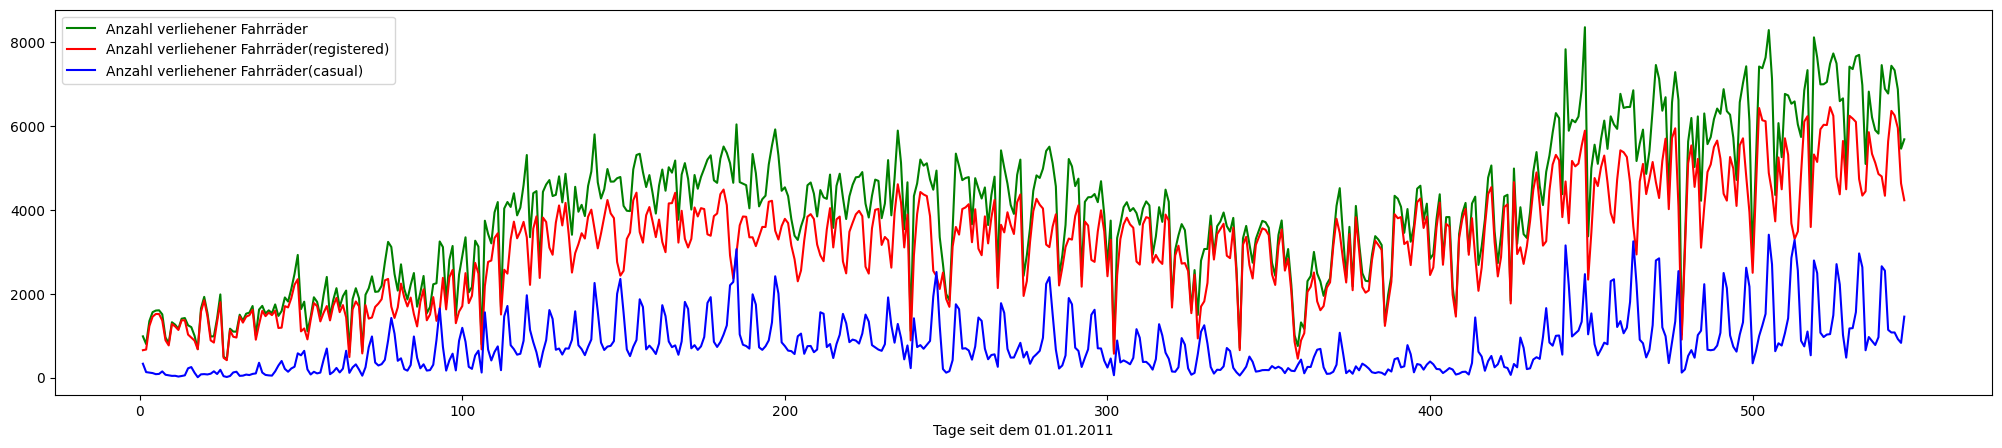

In [50]:
fig, ax = plt.subplots(1, figsize = (25,5))
ax.plot(bike_rental['instant'], bike_rental['cnt'], label = 'Anzahl verliehener Fahrräder', color = 'green')
ax.plot(bike_rental['instant'], bike_rental['registered'], label = 'Anzahl verliehener Fahrräder(registered)', color = 'red')
ax.plot(bike_rental['instant'], bike_rental['casual'], label = 'Anzahl verliehener Fahrräder(casual)', color = 'blue')

ax.set_xlabel('Tage seit dem 01.01.2011')
ax.legend()

#### Interpretation der Grafik
Die Verläufe der verliehenen Fahrräder zeigen einen sesonallen Trend. So werden im Sommer insgesamt mehr Fahrräder ausgeliehen als über die Winterzeit.
* registered: Die Anzahl der verliehenen Fahrräder an registrierte Benutzer macht einen Großteil der gesamten verliehenen Fahrräder aus. Es ist zu sehen, dass die Werte an Wochenenden und vermutlich besonders stark an Feiertagen einbrechen.
* casual: Verliehene Fahrräder an nicht-registrierte Benutzer haben sehr starke peaks im Sommer und Herbst an Wochenendtagen

# 3) Abhängigkeit der Histogramme und Scatter-Plots vom Wetter
In den Grafiken wird das Wetter farblich makiert. So werden Tage mit gutem Wetter (Wert 1) pink dargestellt und Tage mit sehr schlechtem Wetter (Wert 4) schwarz. Tage mit sehr schlechtem Wetter sind mit einem X makiert

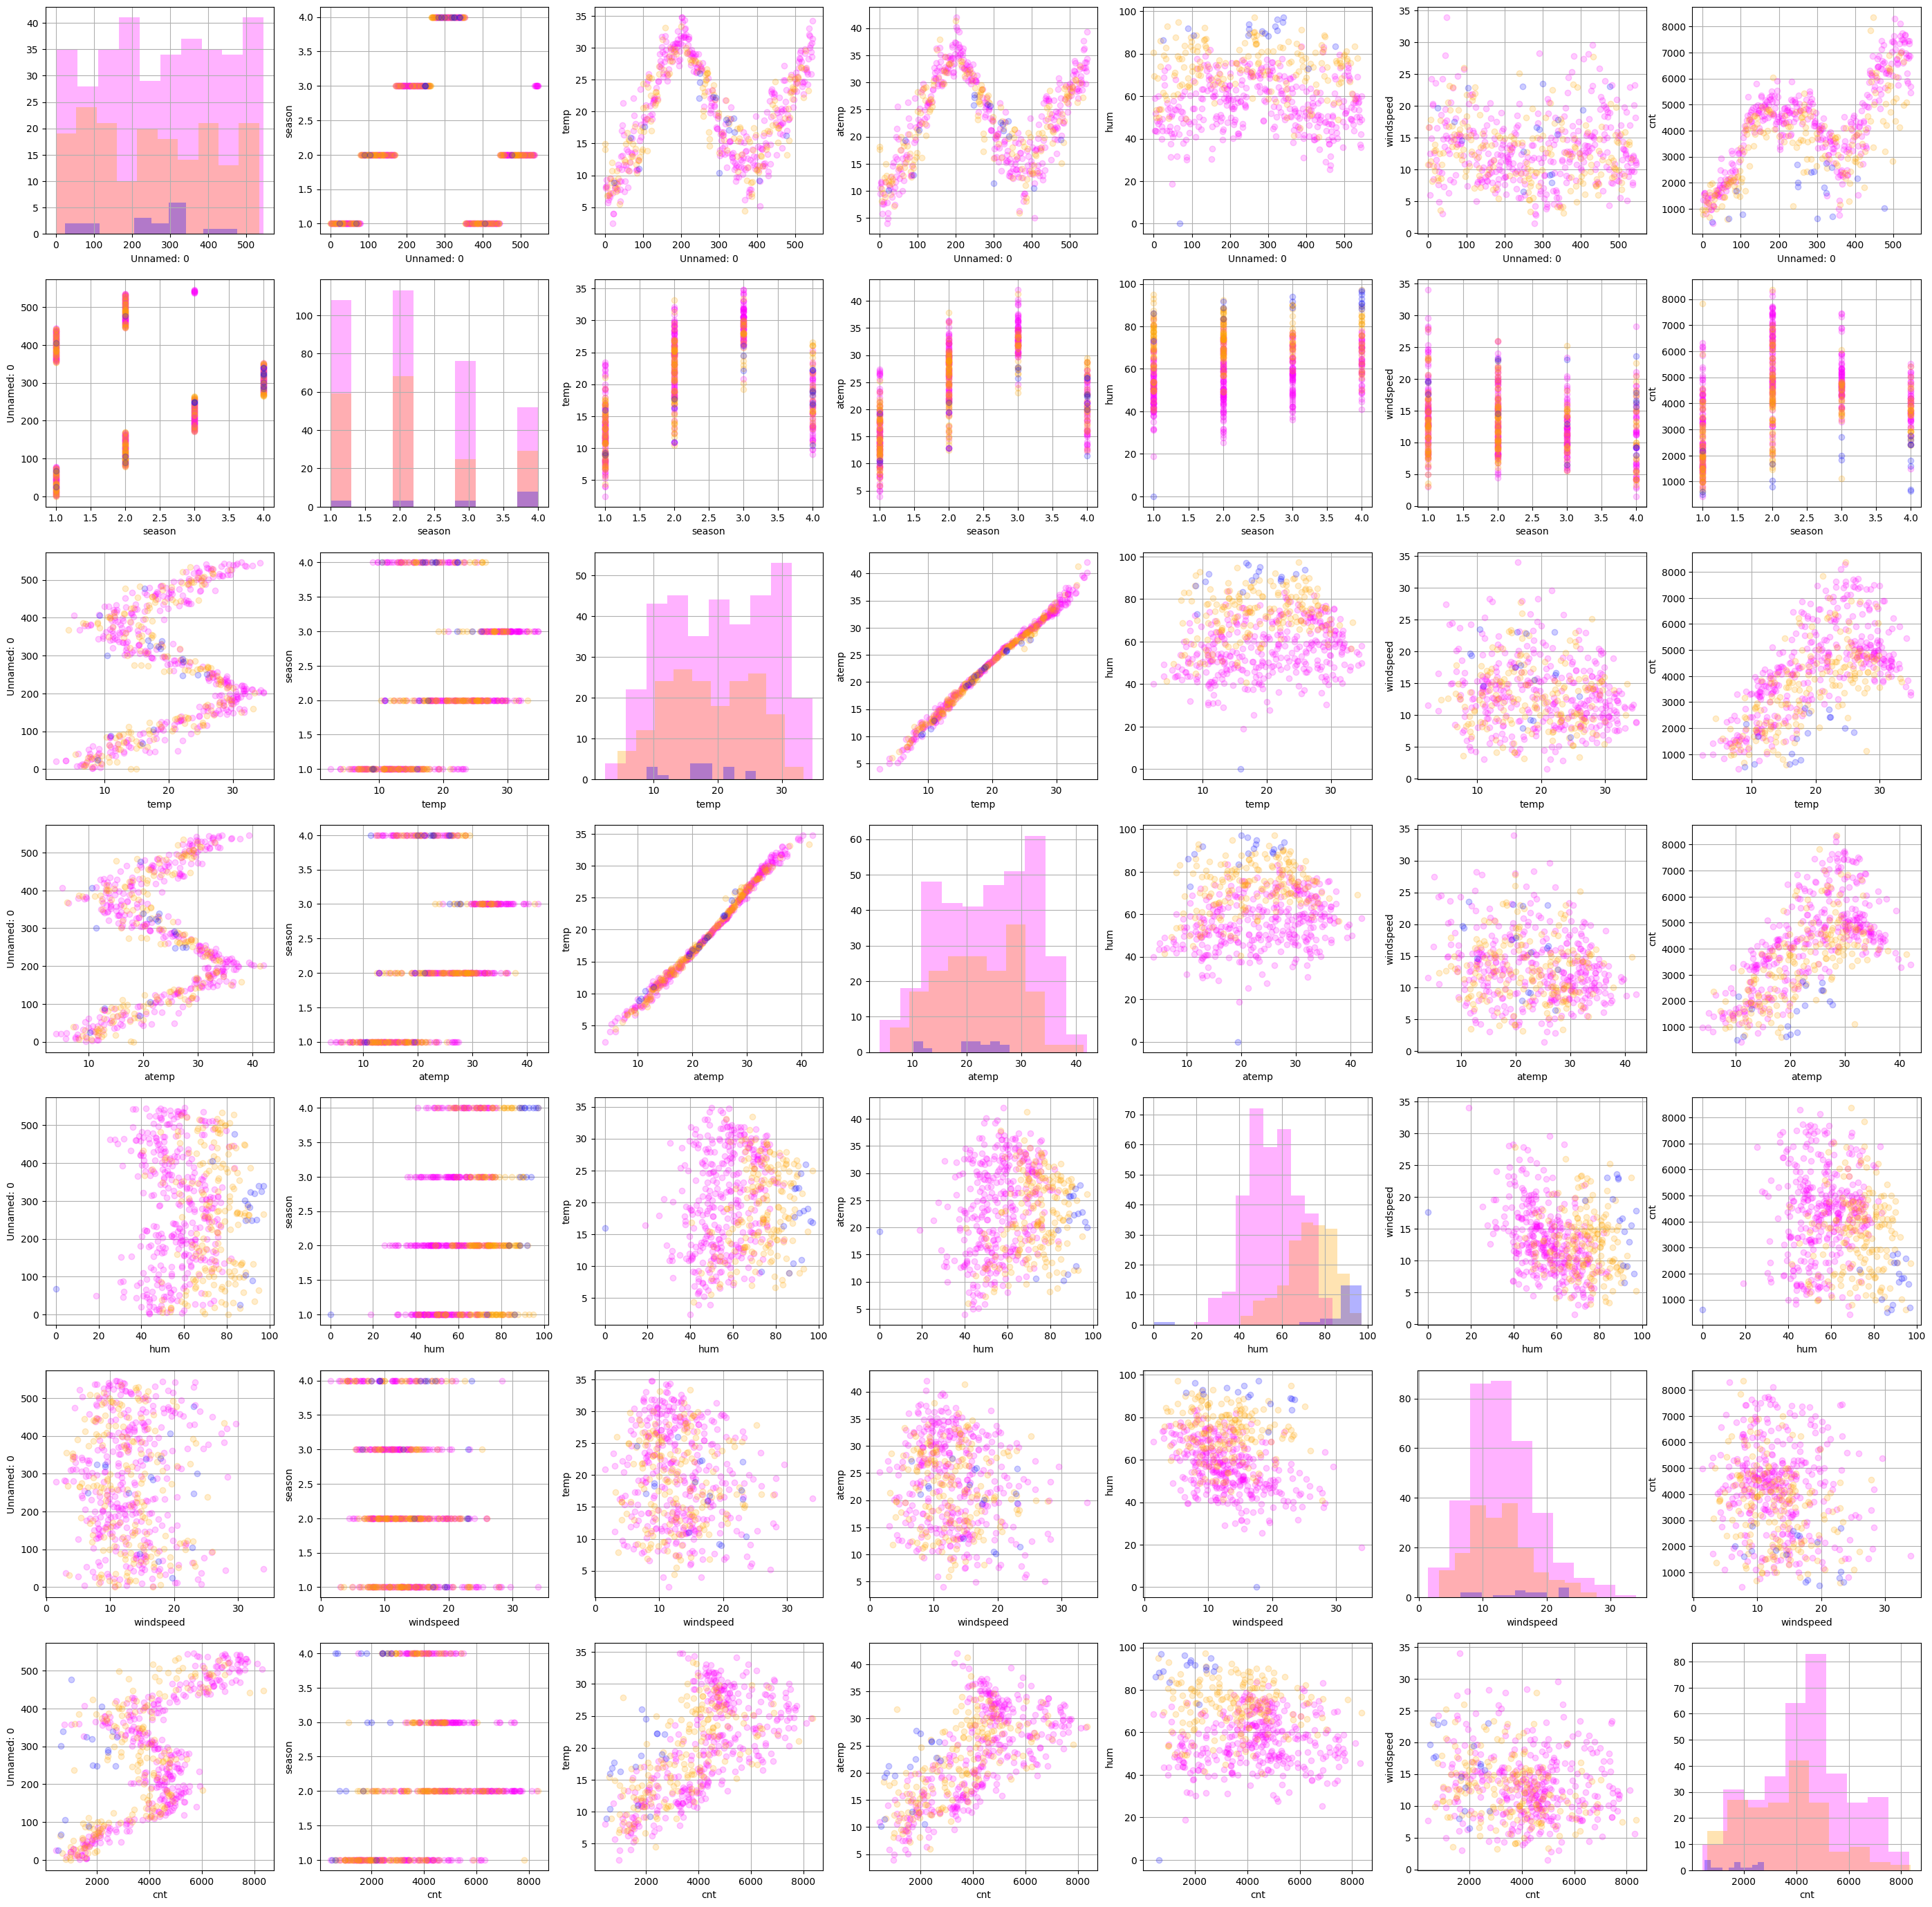

In [51]:
# Codiere Weathersit in Farbe

no_show_columns=  ['instant','dteday','intday','casual','registered','weathersit','yr','mnth','holiday','weekday','workingday']
n=len(bike_rental.columns)-len(no_show_columns)
show_columns=list(bike_rental.columns)
for column in no_show_columns:
    show_columns.remove(column)
    
spec_feat='weathersit'  # Features nach welchem ich Farblich unterscheiden soll
specials=np.sort(np.unique(bike_rental[spec_feat].values))  # Liste der verschiedenen Einträge von weathersit
color_dict={1:'fuchsia',  # 1: Clear, Few clouds, Partly cloudy
            2:'orange',   # 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3:'blue',     # 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4:'black'}    # 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

fig,ax=plt.subplots(n,n,figsize=(35,35))
for i,key in  enumerate(show_columns):
    for j,key2 in enumerate(show_columns):
        if key==key2:
            for spec in specials:
                cond=(bike_rental[spec_feat]==spec)
                ax[i][i].hist(bike_rental[key].loc[cond],color=color_dict[spec],alpha=0.3,label=key)
            ax[i][i].set_xlabel(key)
        else:
            for spec in specials:
                cond=(bike_rental[spec_feat]==spec)
                ax[i][j].plot(bike_rental[key].loc[cond],bike_rental[key2].loc[cond],ls='',marker='o',alpha=0.2,color=color_dict[spec])
            ax[i][j].set_xlabel(key)
            ax[i][j].set_ylabel(key2)
        cond_ws4 = (bike_rental[spec_feat] == 4)
        ax[i][j].plot(
                bike_rental[key].loc[cond_ws4], bike_rental[key2].loc[cond_ws4], 
                ls='', marker='x', markersize=12, color='black', label='Extreme Wetterlage (weathersit=4)'
        )
        ax[i][j].grid(True)

##### Gibt es Daten mit sehr schlechtem Wetter?

In [52]:
cond_ws4 = (bike_rental['weathersit'] == 4)

count_ws4 = cond_ws4.sum()

if count_ws4 > 0:
    print(f"Es existieren {count_ws4} Datenelement(e) mit weathersit = 4.")
    print(bike_rental[cond_ws4]) 
else:
    print("Es existieren keine Datenelemente mit weathersit = 4.")

Es existieren keine Datenelemente mit weathersit = 4.


# 4) Erstellen einer neuen Variable

#### Definition der neuen Variable
* Feuchtigkeit-Temperatur Koeffizient: hum/temp -> wie feucht es relativ zur Temperatur ist

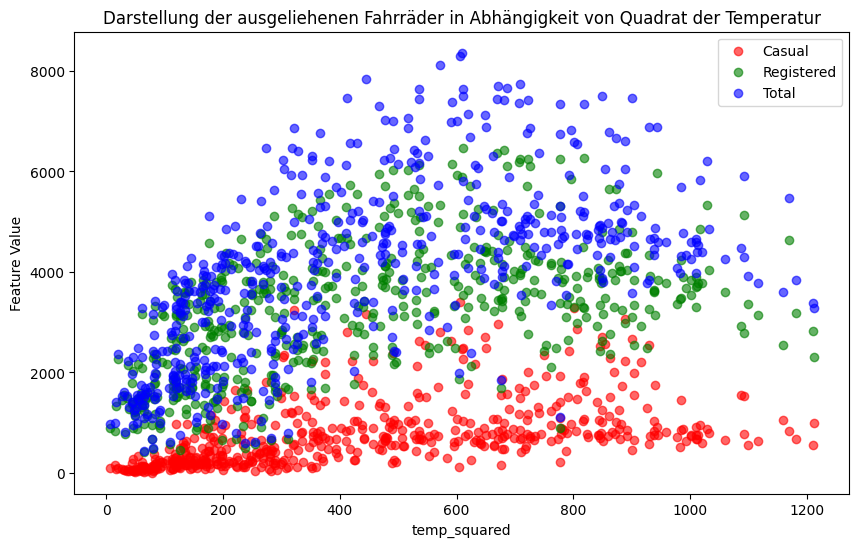

In [53]:
from numpy import log
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Min-Max-Skalierung
bike_rental['temp_squared'] = bike_rental['temp'] * bike_rental['temp']

# Plot erstellen
used_features = ["casual", "registered", "cnt"]
colors = ['r', 'g', 'b']
labels = ['Casual', 'Registered', 'Total']

plt.figure(figsize=(10, 6))
for feature, color, label in zip(used_features, colors, labels):
    plt.scatter(bike_rental['temp_squared'], bike_rental[feature], color=color, alpha=0.6, label=label)

plt.xlabel("temp_squared")
plt.ylabel("Feature Value")
plt.title("Darstellung der ausgeliehenen Fahrräder in Abhängigkeit von Quadrat der Temperatur")
plt.legend()
plt.show()

In der Grafik ist zu sehen, dass mit zunehmend hoher Temperatur die Anzahl an ausgeliehenen Fahrrädern wieder abnimmt

#### Korrelation

In [54]:
correlation_humtemp_quo_cnt = bike_rental['temp_squared'].corr(bike_rental['cnt'])
print(f'Korrelation zwischen der neuen Variable "temp_squared" zu "cnt": {correlation_humtemp_quo_cnt}')

Korrelation zwischen der neuen Variable "temp_squared" zu "cnt": 0.5908744553628796


# 5) Fehlerkorrektur

#### Fehlerermittlung
* Ein Fehler tritt am 69. Tag auf. Hier ist im Datensatz für den Wert der Luftfeuchtigkeit der Wert 0 angegeben, was nicht stimmen kann.

* Der gröbere Fehler ist, dass die Jahreszeiten im Readme wie folgt definiert sind: season (1:springer, 2:summer, 3:fall, 4:winter). Jedoch beginnen die Datensätze mit dem Wert 1 für Frühling, obwohl sie im Jänner mit dem Wert 4 für Winter anfangen sollten

#### Darstellung mit ausgebessertem Fehler

* Ausbessern der Season Werte im DataFrame sodass sie mit dem Readme überein stimmen

In [55]:
season_correction = {
    1: 4,  # Winter
    2: 1,  # Spring
    3: 2,  # Summer
    4: 3   # Fall
}

# Wende das Mapping an
bike_rental['season_corrected'] = bike_rental['season'].map(season_correction)

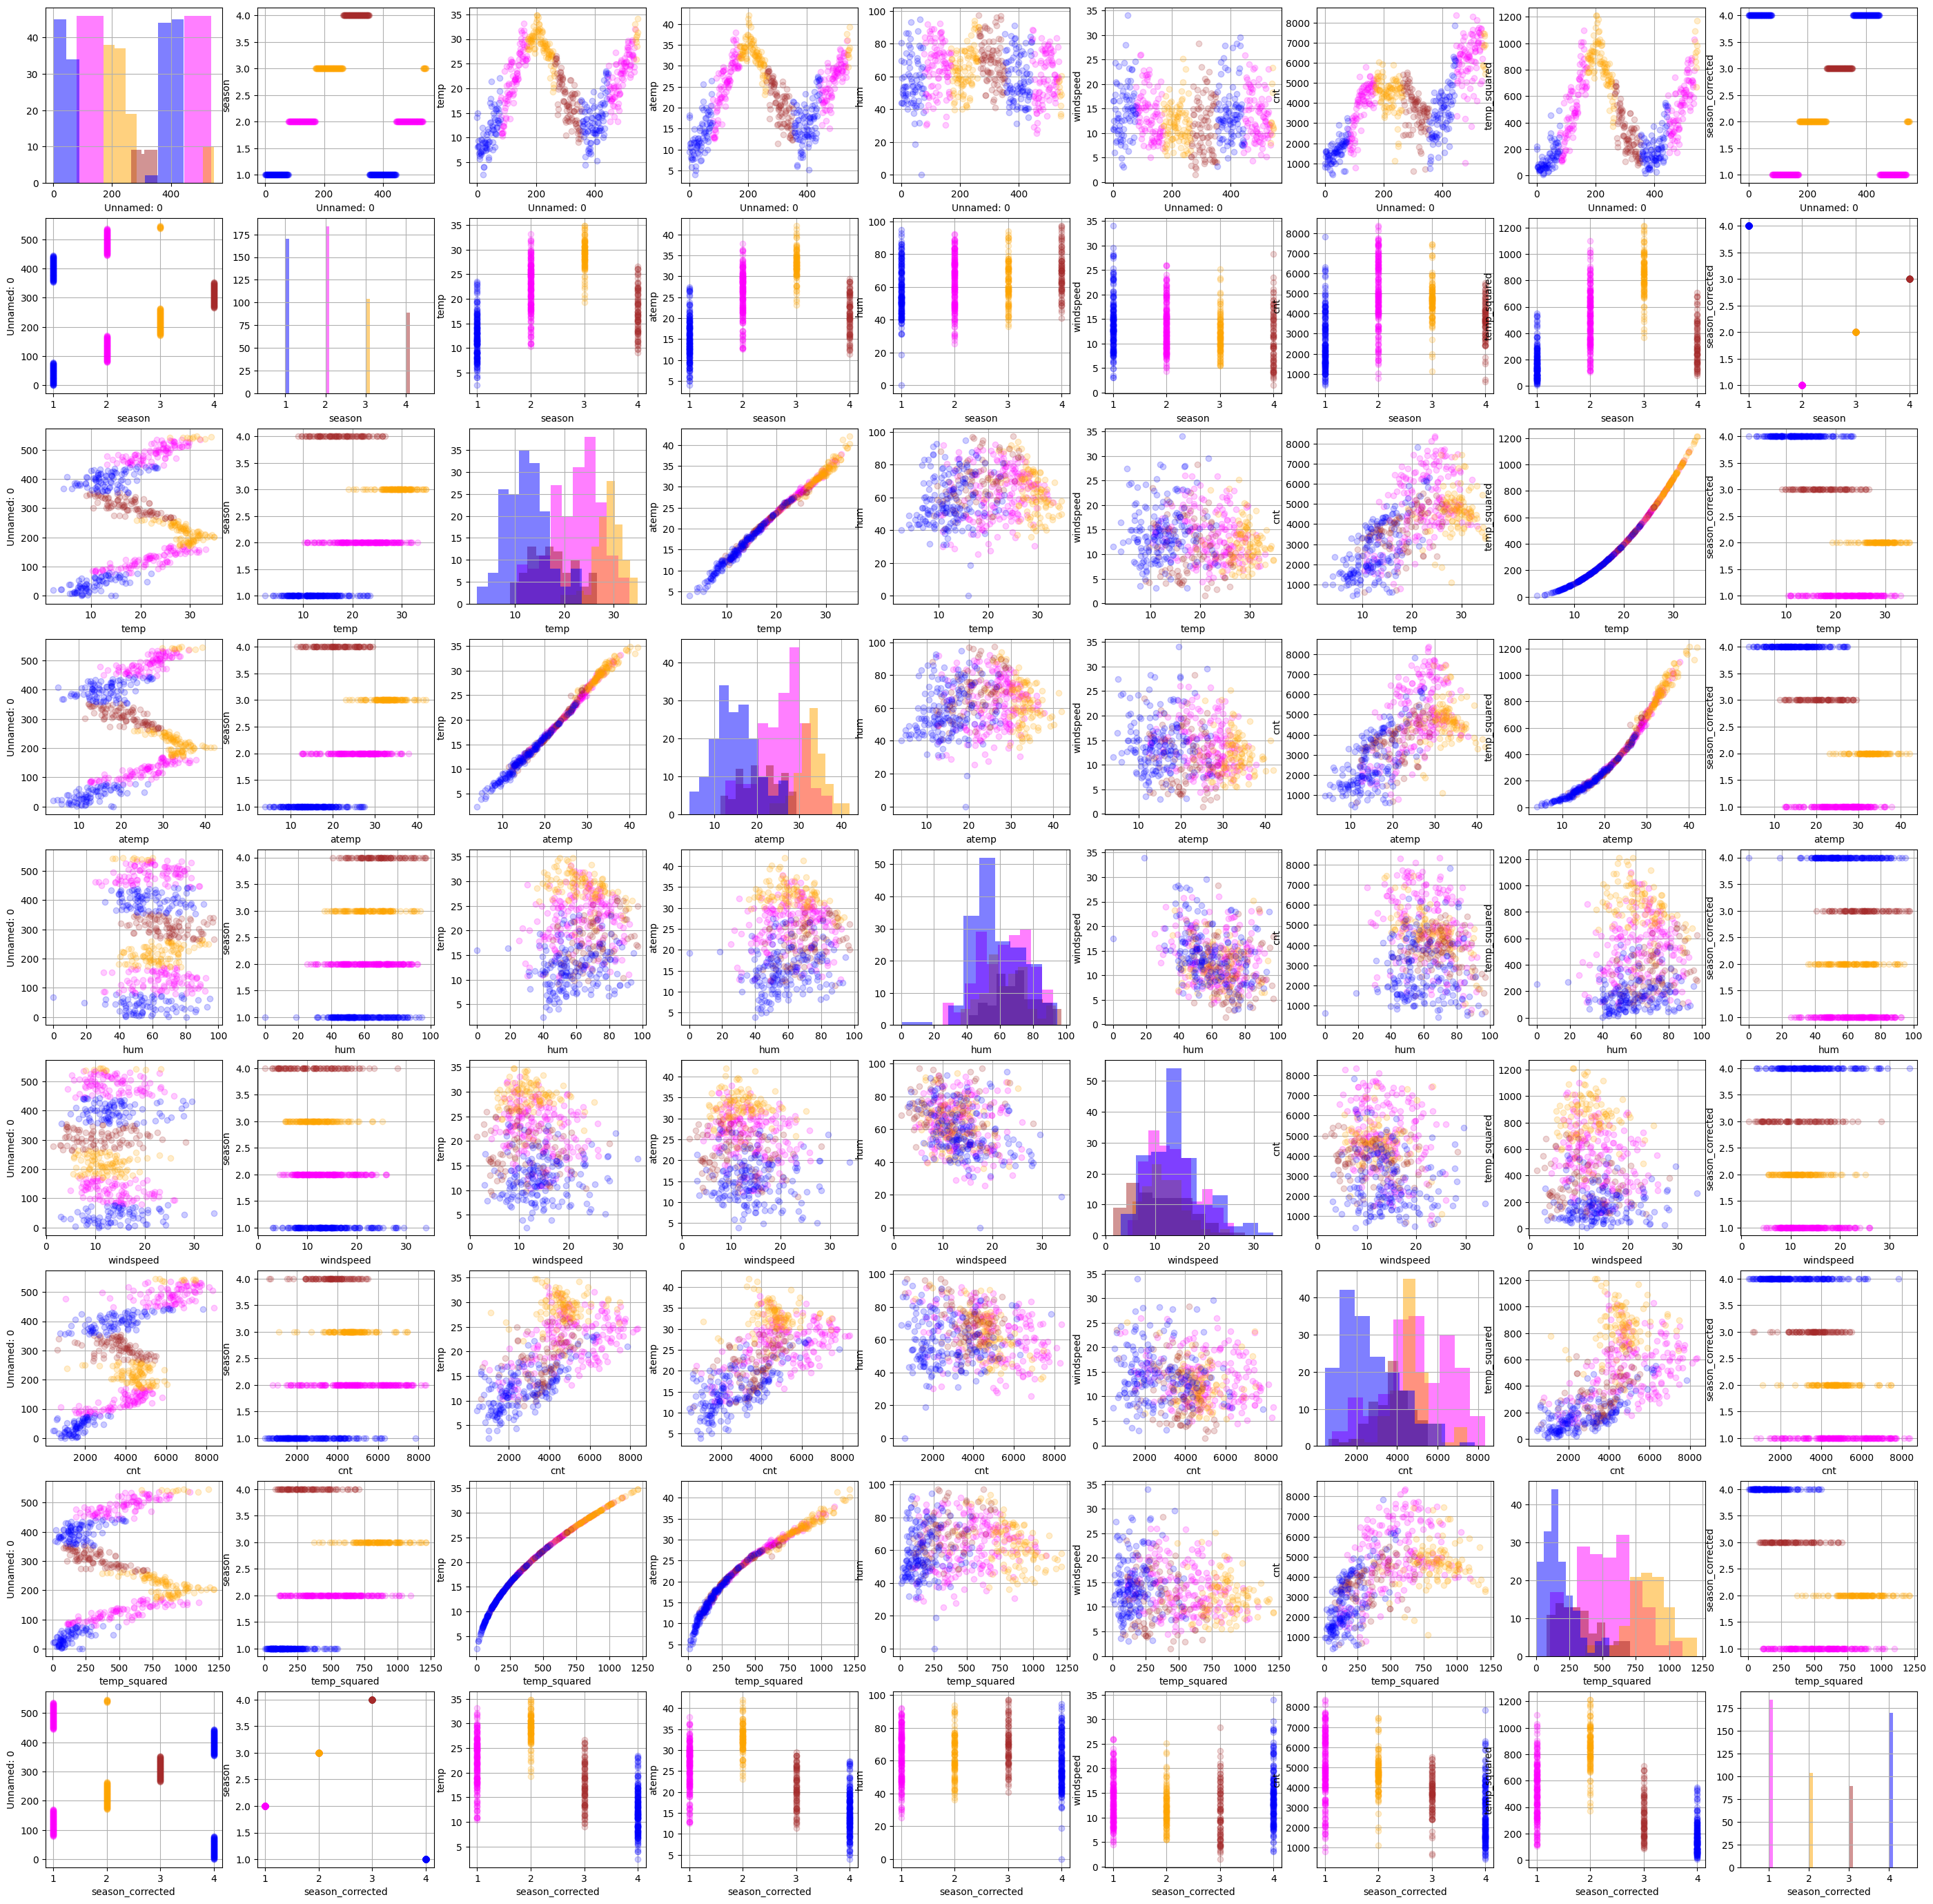

In [57]:
no_show_columns=  ['instant','dteday','intday','casual','registered','weathersit','yr','mnth','holiday','weekday','workingday']
n=len(bike_rental.columns)-len(no_show_columns)
show_columns=list(bike_rental.columns)
for column in no_show_columns:
    show_columns.remove(column)
    
spec_feat='season_corrected'  
specials=np.sort(np.unique(bike_rental[spec_feat].values)) 
color_dict={1:'fuchsia',  #season (1:springer, 2:summer, 3:fall, 4:winter)
            2:'orange',  
            3:'brown',     
            4:'blue'}    

fig,ax=plt.subplots(n,n,figsize=(35,35))
for i,key in  enumerate(show_columns):
    for j,key2 in enumerate(show_columns):
        if key==key2:
            for spec in specials:
                cond=(bike_rental[spec_feat]==spec)
                ax[i][i].hist(bike_rental[key].loc[cond],color=color_dict[spec],alpha=0.5,label=key)
            ax[i][i].set_xlabel(key)
        else:
            for spec in specials:
                cond=(bike_rental[spec_feat]==spec)
                ax[i][j].plot(bike_rental[key].loc[cond],bike_rental[key2].loc[cond],ls='',marker='o',alpha=0.2,color=color_dict[spec])
            ax[i][j].set_xlabel(key)
            ax[i][j].set_ylabel(key2)
        ax[i][j].grid(True)